### Load Libraries

In [242]:
!pip install wordcloud

In [243]:
# Load libraries

# !pip install pandas
# !pip install sklearn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import spacy
# from collections import Counter
import re
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from wordcloud import WordCloud
from nltk.corpus import stopwords

### Load data

In [244]:
# read data
df = pd.read_csv('data/data.csv')
df.head()

,body,clusters_0,sentiment_positive_score,sentiment_negative_score,sentiment_combined_score,sentiment_summary,published_date,post_type,total_engagement,comments,shares,likes,author_gender,followers
0,During the pandemic government workers have de...,Poor Pay,7.170060,1.118036,1.511767,positive,"Nov 22, 2020",Reposts,0,0,0,0,Unknown,45747
1,I didn’t realize how poor I was until I got a ...,Poor Pay,3.428319,4.349932,-0.584664,negative,"May 7, 2021",Reposts,0,0,0,0,Female,82152
2,British people have this really dumb complex w...,Cost of Living,1.277756,3.769611,-1.428440,negative,"Jan 2, 2021",Reposts,0,0,0,0,Unknown,13581
3,Tory MPs have voted against a ban on residents...,Poor Pay,3.365988,5.851462,-0.899544,negative,"Apr 27, 2021",Reposts,0,0,0,0,Male,2976
4,The trouble with Rishi Sunak's upbeat message ...,Wage Growth,5.453477,2.944297,0.269810,neutral,"Oct 28, 2021",Reposts,0,0,0,0,Male,32501


##### General

In [245]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   body                      1000 non-null   object 
 1   clusters_0                1000 non-null   object 
 2   sentiment_positive_score  1000 non-null   float64
 3   sentiment_negative_score  1000 non-null   float64
 4   sentiment_combined_score  1000 non-null   float64
 5   sentiment_summary         1000 non-null   object 
 6   published_date            1000 non-null   object 
 7   post_type                 1000 non-null   object 
 8   total_engagement          1000 non-null   int64  
 9   comments                  1000 non-null   int64  
 10  shares                    1000 non-null   int64  
 11  likes                     1000 non-null   int64  
 12  author_gender             1000 non-null   object 
 13  followers                 1000 non-null   int64  
dtypes: float6

670 entries. No null values.
Catogrical columns are sentiment_summary, author_gender
Text / Object are body, clusters_0 and post_type
Date type published_date

In [246]:
df.describe()

,sentiment_positive_score,sentiment_negative_score,sentiment_combined_score,total_engagement,comments,shares,likes,followers
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,3.402236,3.554234,-0.377169,9.338000,0.291000,2.400000,6.647000,7578.757000
std,1.439711,1.537124,0.841714,148.947323,3.526578,38.745751,106.932366,31125.442426
min,0.813117,0.638878,-1.942425,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.303243,2.336901,-1.051523,0.000000,0.000000,0.000000,0.000000,322.500000
50%,3.183325,3.490972,-0.394248,0.000000,0.000000,0.000000,0.000000,1294.500000
75%,4.244433,4.640717,0.269810,0.000000,0.000000,0.000000,0.000000,4188.500000
max,7.680856,7.754159,1.753141,4349.000000,97.000000,1126.000000,3126.000000,488136.000000


### Pre-processing

##### Convert Data types

In [247]:
# Get type of columns
def get_col_types(df):
    cols = df.columns
    num_cols = []
    cat_cols = []
    other_cols = []
    for col in cols:
        if df[col].dtype=='object' and col not in ['body','post_type','clusters_0']:
            cat_cols.append(col)
        if df[col].dtype=='int64' or df[col].dtype=='float64':
            num_cols.append(col)
        else:
            other_cols.append(col)
    return cat_cols, num_cols, other_cols

In [248]:
def convert_data_types(df):
    # Convert published_date to datetime
    df['published_date'] = pd.to_datetime(df['published_date'])
    # get columns type
    cat_cols, num_cols, other_cols = get_col_types(df)
    # convert to categorical
    for col in cat_cols:
        df[col] =  df[col].astype("category")
    return df

In [249]:
df = convert_data_types(df)

##### Remove Duplicates

In [250]:
len(df)

1000

In [251]:
# Number of non-unique
df.nunique()

body                        978
clusters_0                   23
sentiment_positive_score    249
sentiment_negative_score    284
sentiment_combined_score    450
sentiment_summary             3
published_date              320
post_type                     3
total_engagement             45
comments                     12
shares                       26
likes                        37
author_gender                 3
followers                   861
dtype: int64

In [252]:
def drop_duplicate_tweets(df):
    df = df.sort_values(by=['post_type'])
    df = df.drop_duplicates(subset='body', keep='first')
    return df

In [253]:
print(len(df))
df = drop_duplicate_tweets(df)
print(len(df))


1000
978


Removed 7 duplicate tweets ('body') removed. Duplicate tweets text are created from Orignal tweets, removing Repost or Replies first

##### Clean Text

In [254]:
# Get vocab
def get_vocab(texts):
    all_words = [word for tokens in texts for word in tokens]
    vocab = sorted(list(set(all_words)))
    return vocab

In [255]:
texts = df['body']
vocab = get_vocab(texts)
print(''.join(vocab))

 !"#$%&'()*+,./0123456789:;=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[]_`abcdefghijklmnopqrstuvwxyz|~ £°½ΆΑΕΖΘΙΚΛΝΠΡΣΤΩϒ‍–—‘’“”…‼₹⃣▪◉☕☹♀♂⚖⚡✅✊✍❌❤➡⬇⭐️🆕🇪🇺🌈🌍🌎🌡🌹🏴🏻🏼🏽🐝👇👉👌👍👏💙💥💪💰📕📢🔴🔺🕊🖕😂😃😉😌😎😘😡😢😥😭😰😱🙁🙄🙏🚌🚍🚑🚨🚩🤔🤡🤨🤪🤬🤯🤷🥀🥱🥴🥵🥺🧡🧵󠁢󠁣󠁥󠁧󠁮󠁳󠁴󠁿


Tweets contain emoticons. These will be learned by the model hence not removing them.

In [256]:
# remove extra spaces
def remove_extra_space(text):
    return ' '.join(text.split())

In [257]:
df['body'] = df['body'].apply(remove_extra_space)

##### Save Data

In [258]:
df.to_csv('./data/train.csv')

### Exploratory Data Analysis

##### Correlation

In [259]:
df.corr()

,sentiment_positive_score,sentiment_negative_score,sentiment_combined_score,total_engagement,comments,shares,likes,followers
sentiment_positive_score,1.000000,-0.580149,0.863778,-0.006166,0.005167,-0.006137,-0.006536,0.020559
sentiment_negative_score,-0.580149,1.000000,-0.878477,0.016396,-0.003595,0.020879,0.015391,0.010513
sentiment_combined_score,0.863778,-0.878477,1.000000,-0.005913,0.011615,-0.008309,-0.005609,-0.000069
total_engagement,-0.006166,0.016396,-0.005913,1.000000,0.953132,0.998022,0.999855,0.139887
comments,0.005167,-0.003595,0.011615,0.953132,1.000000,0.937466,0.954968,0.139645
shares,-0.006137,0.020879,-0.008309,0.998022,0.937466,1.000000,0.996900,0.140565
likes,-0.006536,0.015391,-0.005609,0.999855,0.954968,0.996900,1.000000,0.139313
followers,0.020559,0.010513,-0.000069,0.139887,0.139645,0.140565,0.139313,1.000000


<AxesSubplot:>

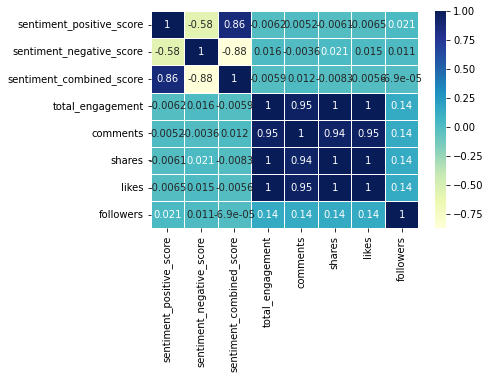

In [260]:
sns.heatmap(df.corr(), annot=True, linewidths=.5, cmap="YlGnBu")

Engagement score correlated with number of followeres, likes, shares, comments
Engagement not correlated with sentiment metrics and vice versa




##### Feature Plots

<AxesSubplot:xlabel='sentiment_summary', ylabel='count'>

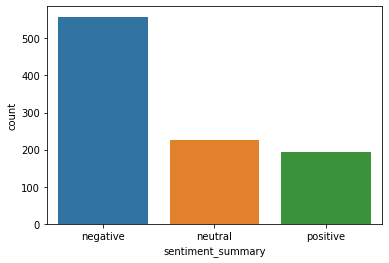

In [261]:
# Sentiment class distribution
sns.countplot(x='sentiment_summary', data=df)

In [262]:
df['sentiment_summary'].value_counts()

negative    558
neutral     226
positive    194
Name: sentiment_summary, dtype: int64

Positve and Neutral sentiments are under represented in the sentiments

<AxesSubplot:xlabel='sentiment_summary', ylabel='sentiment_combined_score'>

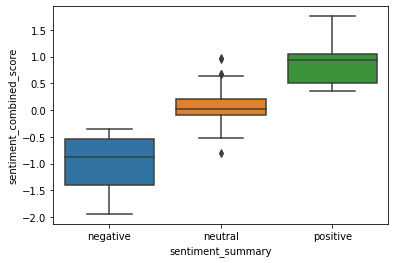

In [263]:
sns.boxplot(x='sentiment_summary',y='sentiment_combined_score',data=df)

There are overlapping sentiments combined score for various classes. Using sentiment_combined_score as target would have allowed model to learn more detailing in sentiment by since the scores overlap amongst sentiment classes, not using sentiment_score as Target. Use sentiment summary as Target

<AxesSubplot:xlabel='author_gender', ylabel='count'>

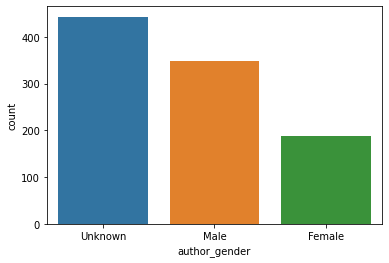

In [264]:
# Gender
sns.countplot(x='author_gender', data=df, order = df['author_gender'].value_counts().index)

<AxesSubplot:xlabel='clusters_0', ylabel='count'>

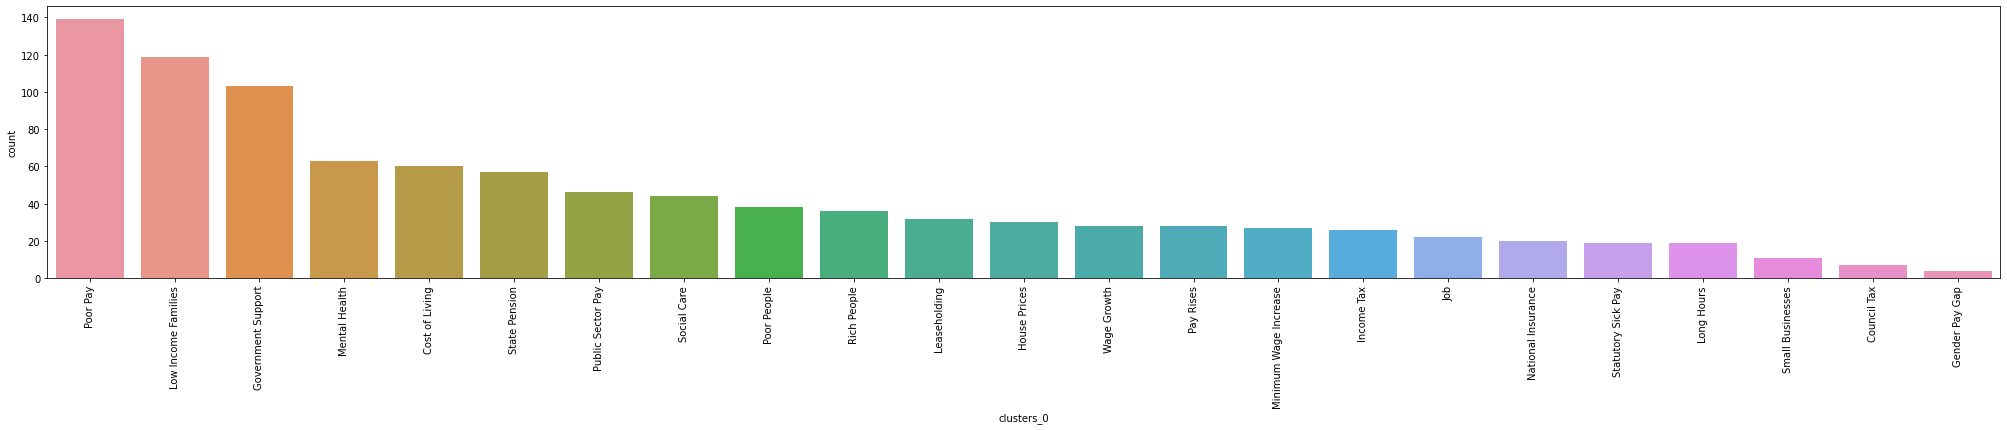

In [265]:
# Topics
plt.figure(figsize=(35,5))
plt.xticks(rotation=90)
sns.countplot(x='clusters_0', data=df, order = df['clusters_0'].value_counts().index)

Topics already provided, hence no need for Topic modelling

<AxesSubplot:xlabel='post_type', ylabel='sentiment_combined_score'>

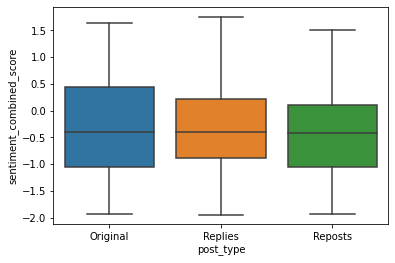

In [266]:
# Post Type
sns.boxplot(x='post_type', y='sentiment_combined_score',data=df)

Most tweets are posted as Orignal. The spread of sentiment of Replies and Repost is similar to the Orignal post, hinting the echo of the orignal sentiment. There isn't much difference in the median score though

<AxesSubplot:xlabel='followers', ylabel='total_engagement'>

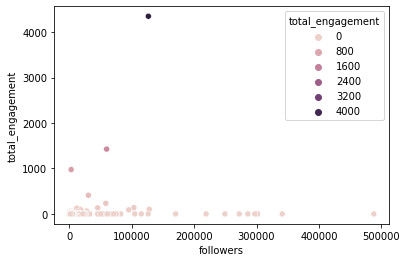

In [267]:
# Followers
sns.scatterplot(data=df, x='followers', y='total_engagement', hue='total_engagement')

<AxesSubplot:xlabel='followers', ylabel='Density'>

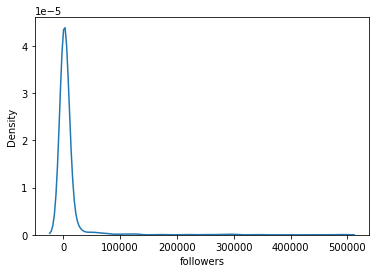

In [268]:
sns.kdeplot(data=df, x='followers')

In [269]:
df['followers'][df['total_engagement'] > 50].sort_values(ascending=False)

55     127929
918    126577
974    103392
961     95082
931     59599
962     58335
976     45322
692     30348
56      27668
57      17770
59      13638
575     12600
978     11888
814     10737
934      2696
561       931
Name: followers, dtype: int64

Very low engagment with tweets even though large amount of followers

<AxesSubplot:xlabel='published_date', ylabel='sentiment_negative_score'>

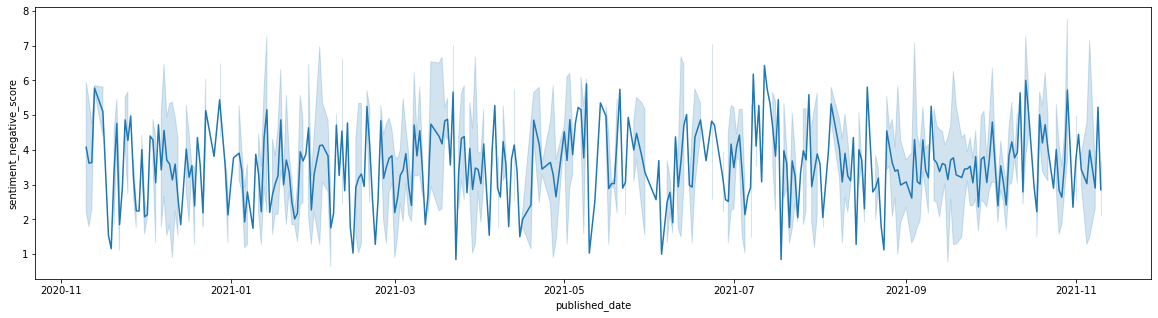

In [270]:
# Date
plt.figure(figsize=(20,5))
sns.lineplot(data=df, x='published_date', y='sentiment_negative_score')

<AxesSubplot:xlabel='published_date', ylabel='sentiment_positive_score'>

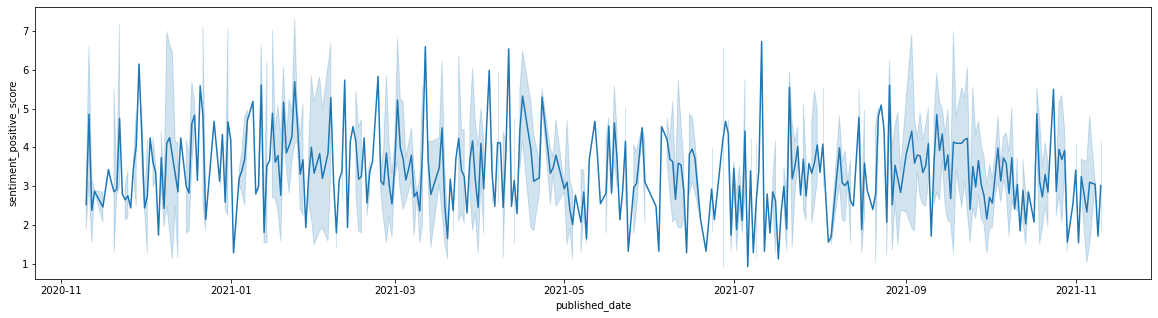

In [271]:
plt.figure(figsize=(20,5))
sns.lineplot(data=df, x='published_date', y='sentiment_positive_score')

<AxesSubplot:xlabel='published_date', ylabel='sentiment_summary'>

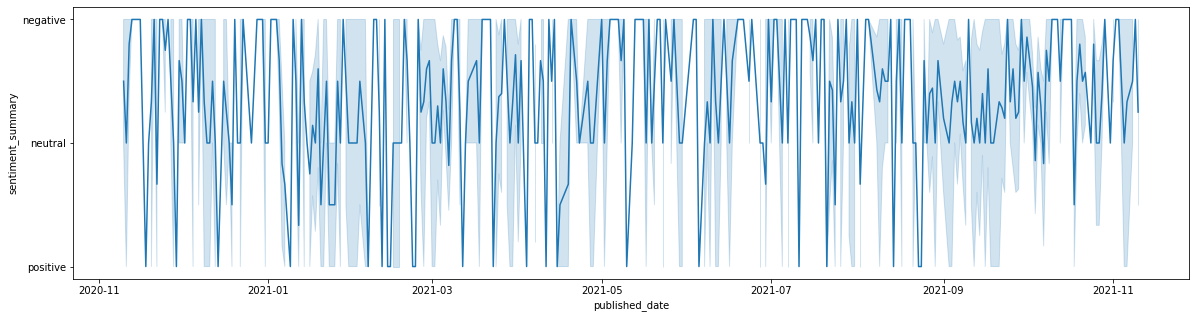

In [272]:
plt.figure(figsize=(20,5))
sns.lineplot(data=df, x='published_date', y='sentiment_summary')

Shows that there is more representation of negative samples. No clearn pattern across time

<AxesSubplot:xlabel='sentiment_positive_score', ylabel='Density'>

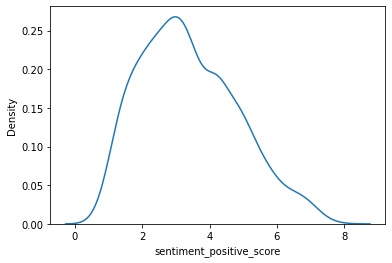

In [273]:
sns.kdeplot(data=df, x='sentiment_positive_score')

<AxesSubplot:xlabel='sentiment_negative_score', ylabel='Density'>

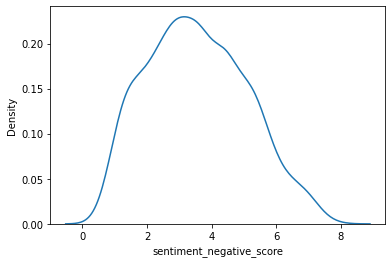

In [274]:
sns.kdeplot(data=df, x='sentiment_negative_score')

<AxesSubplot:xlabel='sentiment_combined_score', ylabel='Density'>

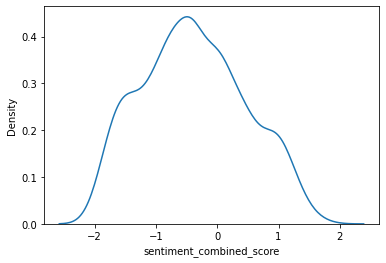

In [275]:
sns.kdeplot(data=df, x='sentiment_combined_score')

Sentiment scores of each class looks normal distributed

### Text Analysis

##### General

In [276]:
texts = df['body']

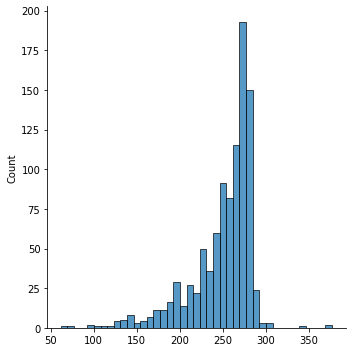

In [277]:
# Tweet length
tweet_lengths = [len(tokens) for tokens in texts]
sns.displot(tweet_lengths)

Max tweet lenght by Twitter is 280. There are some more than 280

In [278]:
def remove_non_alphabets(text):
    regex = re.compile('[^a-zA-Z]')
    text = regex.sub(' ', text)
    text = " ".join(text.split())
    return text

##### Word Cloud

In [279]:

texts = texts.apply(remove_non_alphabets)
texts[1]

'I didn t realize how poor I was until I got a good job Education and a middle class salary can not undo the long term economic and emotional damage of living most of your life in poverty'

In [280]:
def get_word_frequencies(texts):
    fdist = FreqDist()
    for text in texts:
        for word in word_tokenize(text):
            if len(word)>2 and word not in stopwords.words('english'):
                fdist[word.lower()] += 1
    most_common_count = [x[1] for x in fdist.most_common(30)]
    most_common_word = [x[0] for x in fdist.most_common(30)]
    top_30_dictionary = dict(zip(most_common_word, most_common_count))
    return top_30_dictionary


In [281]:
def create_wordcloud(top_30_dictionary):
    wordcloud = WordCloud(colormap = 'Accent', background_color = 'black').generate_from_frequencies(top_30_dictionary)
    #plot with matplotlib
    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.savefig('top_30_cloud.png')
    plt.show()

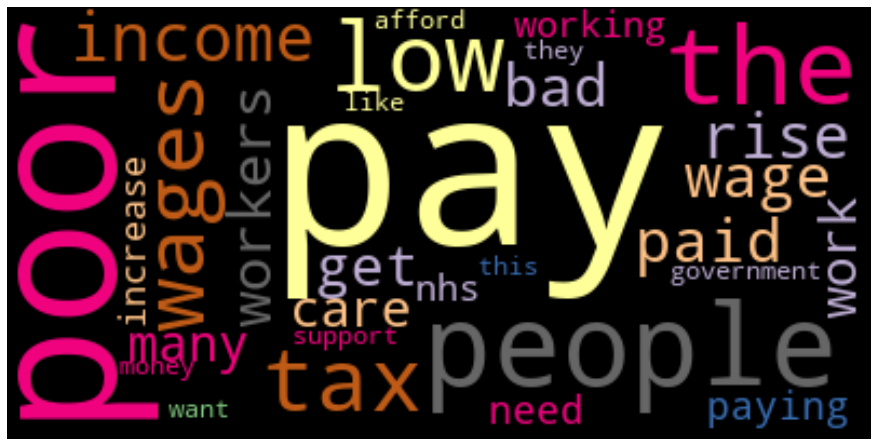

In [282]:
top_30_dictionary = get_word_frequencies(texts)
create_wordcloud(top_30_dictionary)